In [237]:
import time
import os

from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

class CNNClass():
    def __init__(self, model, transform, params, name,
                 path = 'data/full',
                 criterion = nn.CrossEntropyLoss(), 
                 optimizer = None,
                 device = 'cuda',
                 lr = 0.001):
        
        self.model = model
        self.transform = transform
        
        train_data = ImageFolder(f'{path}/train', transform=transform)
        valid_data = ImageFolder(f'{path}/valid', transform=transform)
        
        self.train_loader = DataLoader(train_data, batch_size=params['BATCH_SIZE'], shuffle=True, num_workers=2)
        self.valid_loader = DataLoader(valid_data, batch_size=params['BATCH_SIZE'], shuffle=True, num_workers=2)
        self.params = params
        self.name = name
        
        if not os.path.exists(f'weights/{self.name}'):
            os.mkdir(f'weights/{self.name}')

        self.criterion = criterion
        if optimizer == None:
            self.optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        else:
            self.optimizer = optimizer
        self.device = device

    def test(self, path='data/full/test', debug=False):
        test_data = ImageFolder(path, transform=self.transform)
        test_loader = DataLoader(test_data, batch_size=self.params['BATCH_SIZE'], shuffle=True, num_workers=2)

        self.model.load_state_dict(torch.load(f'weights/{self.name}/{self.name}.pth', 
                                              map_location=self.device)['model'])
        self.optimizer.load_state_dict(torch.load(f'weights/{self.name}/{self.name}.pth',
                                                  map_location=self.device)['optimizer'])

        correct = 0
        total = 0
        self.model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy

# MODEL 1

In [238]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        img, label = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]        
        return (img, label ,path)
    
test_data = ImageFolderWithPaths('data/full/test', transform=transform_sample)
test_loader = DataLoader(test_data, batch_size=1)

train_data = ImageFolderWithPaths('data/full/train', transform=transform_sample)
train_loader = DataLoader(train_data, batch_size=1)

valid_data = ImageFolderWithPaths('data/full/valid', transform=transform_sample)
valid_loader = DataLoader(valid_data, batch_size=1)

# Save labels and features from different models

## Model 1

In [5]:
from torchvision.models import alexnet, AlexNet_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = AlexNet_Weights.DEFAULT
model_sample = alexnet(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 50,
                'EARLY_STOP': 5}

model1 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  name='alexnet_native')

In [18]:
model1.model.load_state_dict(torch.load(f'weights/{model1.name}/{model1.name}.pth', 
                                        map_location='cpu')['model'])
model1.optimizer.load_state_dict(torch.load(f'weights/{model1.name}/{model1.name}.pth',
                                            map_location='cpu')['optimizer'])


# TEST LOADER
features = []
names = []
true_labels = []

model1.model.eval()
with torch.no_grad():
    for images, labels, name in test_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model1.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model1_data_test = pd.DataFrame(features, index=names)
model1_data_test['class'] = true_labels


# TRAIN_LOADER
features = []
names = []
true_labels = []

model1.model.eval()
with torch.no_grad():
    for images, labels, name in train_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model1.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model1_data_train = pd.DataFrame(features, index=names)
model1_data_train['class'] = true_labels
        
# VALID_LOADER
features = []
names = []
true_labels = []

model1.model.eval()
with torch.no_grad():
    for images, labels, name in valid_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model1.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)

model1_data_valid = pd.DataFrame(features, index=names)
model1_data_valid['class'] = true_labels

In [19]:
full_data = pd.concat([model1_data_valid, model1_data_test, model1_data_train])
full_data.to_csv('catboost_csv/model1_outputs.csv')

In [22]:
full_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,class
data/full/valid/air hockey/1.jpg,15.988851,-2.725464,-0.549372,-1.089421,-2.030747,6.951275,-1.055975,3.918266,4.581448,1.235481,...,-1.241654,3.45839,5.38839,-2.031516,-1.620875,-2.175141,-0.113895,-3.10183,-2.357223,0


## Model 2

In [23]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features, 100)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model2 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='resnet50_native')

In [24]:
model2.model.load_state_dict(torch.load(f'weights/{model2.name}/{model2.name}.pth', 
                                        map_location='cpu')['model'])
model2.optimizer.load_state_dict(torch.load(f'weights/{model2.name}/{model2.name}.pth',
                                            map_location='cpu')['optimizer'])


# TEST LOADER
features = []
names = []
true_labels = []

model2.model.eval()
with torch.no_grad():
    for images, labels, name in test_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model2.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model2_data_test = pd.DataFrame(features, index=names)
model2_data_test['class'] = true_labels


# TRAIN_LOADER
features = []
names = []
true_labels = []

model2.model.eval()
with torch.no_grad():
    for images, labels, name in train_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model2.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model2_data_train = pd.DataFrame(features, index=names)
model2_data_train['class'] = true_labels
        
# VALID_LOADER
features = []
names = []
true_labels = []

model2.model.eval()
with torch.no_grad():
    for images, labels, name in valid_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model2.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)

model2_data_valid = pd.DataFrame(features, index=names)
model2_data_valid['class'] = true_labels

full_data = pd.concat([model2_data_valid, model2_data_test, model2_data_train])
full_data.to_csv('catboost_csv/model2_outputs.csv')

## Model 3

In [25]:
from torchvision.models import inception_v3, Inception_V3_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = Inception_V3_Weights.DEFAULT
model_sample = inception_v3(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features,
                      100)
model_sample.aux_logits=False
model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model3 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  name='inception-v3_native')

In [26]:
model3.model.load_state_dict(torch.load(f'weights/{model3.name}/{model3.name}.pth', 
                                        map_location='cpu')['model'])
model3.optimizer.load_state_dict(torch.load(f'weights/{model3.name}/{model3.name}.pth',
                                            map_location='cpu')['optimizer'])


# TEST LOADER
features = []
names = []
true_labels = []

model3.model.eval()
with torch.no_grad():
    for images, labels, name in test_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model3.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model3_data_test = pd.DataFrame(features, index=names)
model3_data_test['class'] = true_labels


# TRAIN_LOADER
features = []
names = []
true_labels = []

model3.model.eval()
with torch.no_grad():
    for images, labels, name in train_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model3.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model3_data_train = pd.DataFrame(features, index=names)
model3_data_train['class'] = true_labels
        
# VALID_LOADER
features = []
names = []
true_labels = []

model3.model.eval()
with torch.no_grad():
    for images, labels, name in valid_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model3.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)

model3_data_valid = pd.DataFrame(features, index=names)
model3_data_valid['class'] = true_labels

full_data = pd.concat([model3_data_valid, model3_data_test, model3_data_train])
full_data.to_csv('catboost_csv/model3_outputs.csv')

## Model 4

In [27]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_B3_Weights.DEFAULT
model_sample = efficientnet_b3(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=100)
)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model4 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='efficientnet-b3_native')

In [28]:
model4.model.load_state_dict(torch.load(f'weights/{model4.name}/{model4.name}.pth', 
                                        map_location='cpu')['model'])
model4.optimizer.load_state_dict(torch.load(f'weights/{model4.name}/{model4.name}.pth',
                                            map_location='cpu')['optimizer'])


# TEST LOADER
features = []
names = []
true_labels = []

model4.model.eval()
with torch.no_grad():
    for images, labels, name in test_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model4.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model4_data_test = pd.DataFrame(features, index=names)
model4_data_test['class'] = true_labels


# TRAIN_LOADER
features = []
names = []
true_labels = []

model4.model.eval()
with torch.no_grad():
    for images, labels, name in train_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model4.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model4_data_train = pd.DataFrame(features, index=names)
model4_data_train['class'] = true_labels
        
# VALID_LOADER
features = []
names = []
true_labels = []

model4.model.eval()
with torch.no_grad():
    for images, labels, name in valid_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model4.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)

model4_data_valid = pd.DataFrame(features, index=names)
model4_data_valid['class'] = true_labels

full_data = pd.concat([model4_data_valid, model4_data_test, model4_data_train])
full_data.to_csv('catboost_csv/model4_outputs.csv')

## Model 5

In [29]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ViT_B_16_Weights.DEFAULT
model_sample = vit_b_16(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.heads.head = nn.Linear(model_sample.heads.head.in_features, 100)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model5 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.001, momentum=0.9, weight_decay=0.03),
                  name='vit-b-16_native')

In [30]:
model5.model.load_state_dict(torch.load(f'weights/{model5.name}/{model5.name}.pth', 
                                        map_location='cpu')['model'])
model5.optimizer.load_state_dict(torch.load(f'weights/{model5.name}/{model5.name}.pth',
                                            map_location='cpu')['optimizer'])


# TEST LOADER
features = []
names = []
true_labels = []

model5.model.eval()
with torch.no_grad():
    for images, labels, name in test_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model5.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model5_data_test = pd.DataFrame(features, index=names)
model5_data_test['class'] = true_labels


# TRAIN_LOADER
features = []
names = []
true_labels = []

model5.model.eval()
with torch.no_grad():
    for images, labels, name in train_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model5.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model5_data_train = pd.DataFrame(features, index=names)
model5_data_train['class'] = true_labels
        
# VALID_LOADER
features = []
names = []
true_labels = []

model5.model.eval()
with torch.no_grad():
    for images, labels, name in valid_loader:
        y_true = int(labels.cpu().numpy())
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model5.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)

model5_data_valid = pd.DataFrame(features, index=names)
model5_data_valid['class'] = true_labels

full_data = pd.concat([model5_data_valid, model5_data_test, model5_data_train])
full_data.to_csv('catboost_csv/model5_outputs.csv')

!python -m  pip install catboost-dev[widget]==1.2rc0

# Use Catboost!

In [22]:
from catboost import CatBoostClassifier
import glob
import pandas as pd
import numpy as np

In [96]:
files = glob.glob('catboost_csv/*')
df_model1 = pd.read_csv(files[0])
y = df_model1['class']
df_model1 = df_model1.iloc[:,:-1]
df_model1.columns = ['path'] + ['model1_'+str(i) for i in range (1, 101)]

df_model2 = pd.read_csv(files[1])
df_model2 = df_model2.iloc[:,:-1]
df_model2.columns = ['path'] + ['model2_'+str(i) for i in range (1, 101)]

df_model3 = pd.read_csv(files[2])
df_model3 = df_model3.iloc[:,:-1]
df_model3.columns = ['path'] + ['model3_'+str(i) for i in range (1, 101)]

df_model4 = pd.read_csv(files[3])
df_model4 = df_model4.iloc[:,:-1]
df_model4.columns = ['path'] + ['model4_'+str(i) for i in range (1, 101)]

df_model5 = pd.read_csv(files[4])
df_model5 = df_model5.iloc[:,:-1]
df_model5.columns = ['path'] + ['model5_'+str(i) for i in range (1, 101)]

In [97]:
df = df_model1.merge(df_model2,
                     on='path').merge(df_model3,
                                      on='path').merge(df_model4,
                                                       on='path').merge(df_model5,
                                                                        on='path')
#df.drop(885, inplace=True)

In [98]:
df['y'] = y

In [99]:
train = df[df['path'].str.contains('train')].sample(frac = 1, random_state=11)
valid = df[df['path'].str.contains('valid')].sample(frac = 1, random_state=11)
test = df[df['path'].str.contains('test')].sample(frac = 1, random_state=11)

In [100]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [101]:
X_train = train.iloc[:,1:-1]
y_train = train['y']

X_test_initial = test.copy()
X_test = test.iloc[:,1:-1]
y_test = test['y']

X_valid = valid.iloc[:,1:-1]
y_valid = valid['y']

In [102]:
y_test_initial = y_test.copy()

y_train = np.squeeze(pd.get_dummies(y_train))
y_valid = np.squeeze(pd.get_dummies(y_valid))
y_test = np.squeeze(pd.get_dummies(y_test))

## CATBOOST: Model 1

In [ ]:
# fine? 100 epoches: 0.83
clf1 = CatBoostClassifier(loss_function='MultiCrossEntropy', 
                         learning_rate=0.8,
                         max_depth=5, 
                         l2_leaf_reg=5,
                         iterations=2000,
                         eval_metric='Accuracy',
                         use_best_model=True)

clf1.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose_eval=True)
clf1.save_model('catboost_fitted_1.cbm')

y_pred = clf1.predict(X_test)
with open(f'catboost_accuracy1.csv', 'w') as f:
    f.write(str(accuracy_score(y_test, y_pred)))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 12.4s	remaining: 6h 53m 3s
1:	learn: 0.0269673	test: 0.0300000	best: 0.0300000 (1)	total: 23.4s	remaining: 6h 29m 44s
2:	learn: 0.0739022	test: 0.0700000	best: 0.0700000 (2)	total: 34.3s	remaining: 6h 20m 33s
3:	learn: 0.1196581	test: 0.1040000	best: 0.1040000 (3)	total: 45.5s	remaining: 6h 18m 3s
4:	learn: 0.1579723	test: 0.1340000	best: 0.1340000 (4)	total: 56.4s	remaining: 6h 15m 9s
5:	learn: 0.1968022	test: 0.1800000	best: 0.1800000 (5)	total: 1m 7s	remaining: 6h 13m 37s
6:	learn: 0.2455055	test: 0.2100000	best: 0.2100000 (6)	total: 1m 18s	remaining: 6h 12m
7:	learn: 0.2919982	test: 0.2540000	best: 0.2540000 (7)	total: 1m 29s	remaining: 6h 10m 32s
8:	learn: 0.3299440	test: 0.2820000	best: 0.2820000 (8)	total: 1m 40s	remaining: 6h 9m 25s
9:	learn: 0.3743737	test: 0.3280000	best: 0.3280000 (9)	total: 1m 51s	remaining: 6h 8m 41s
10:	learn: 0.4237401	test: 0.3680000	best: 0.3680000 (10)	total: 2m 2s	remaining: 6h 7m 47s
11:

## CATBOOST: Model 2

In [ ]:
clf2 = CatBoostClassifier(loss_function='MultiCrossEntropy', 
                         learning_rate=0.8,
                         max_depth=5,
                         l2_leaf_reg=10,
                         iterations=2000,
                         early_stopping_rounds=30,
                         eval_metric='Accuracy',
                         use_best_model=True)

clf2.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose_eval=True)
clf2.save_model('catboost_fitted_2.cbm')

y_pred = clf2.predict(X_test)
with open(f'catboost_accuracy2.csv', 'w') as f:
    f.write(str(accuracy_score(y_test, y_pred)))

## CATBOOST: Model 3

In [ ]:
clf3 = CatBoostClassifier(loss_function='MultiCrossEntropy', 
                         learning_rate=0.8,
                         max_depth=2,
                         l2_leaf_reg=10,
                         iterations=2000,
                         early_stopping_rounds=30,
                         eval_metric='Accuracy',
                         use_best_model=True)

clf3.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose_eval=True)
clf3.save_model('catboost_fitted_3.cbm')

y_pred = clf3.predict(X_test)
with open(f'catboost_accuracy3.csv', 'w') as f:
    f.write(str(accuracy_score(y_test, y_pred)))

## CATBOOST: Model 4

In [30]:
clf4 = CatBoostClassifier(loss_function='MultiCrossEntropy', 
                          learning_rate=0.8,
                          max_depth=2,
                          l2_leaf_reg=15,
                          iterations=2000,
                          early_stopping_rounds=30,
                          eval_metric='Accuracy',
                          use_best_model=True)

clf4.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose_eval=True)
clf4.save_model('catboost_fitted_4.cbm')

y_pred = clf4.predict(X_test)
with open(f'catboost_accuracy4.csv', 'w') as f:
    f.write(str(accuracy_score(y_test, y_pred)))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.56s	remaining: 1h 25m 29s
1:	learn: 0.0109048	test: 0.0100000	best: 0.0100000 (1)	total: 4.57s	remaining: 1h 16m 7s
2:	learn: 0.0324197	test: 0.0300000	best: 0.0300000 (2)	total: 6.55s	remaining: 1h 12m 39s
3:	learn: 0.0535662	test: 0.0500000	best: 0.0500000 (3)	total: 8.61s	remaining: 1h 11m 36s
4:	learn: 0.0719128	test: 0.0640000	best: 0.0640000 (4)	total: 10.6s	remaining: 1h 10m 40s
5:	learn: 0.0867227	test: 0.0720000	best: 0.0720000 (5)	total: 12.6s	remaining: 1h 9m 51s
6:	learn: 0.1118479	test: 0.0920000	best: 0.0920000 (6)	total: 14.6s	remaining: 1h 9m 11s
7:	learn: 0.1344680	test: 0.1120000	best: 0.1120000 (7)	total: 16.6s	remaining: 1h 8m 44s
8:	learn: 0.1513410	test: 0.1260000	best: 0.1260000 (8)	total: 19.7s	remaining: 1h 12m 38s
9:	learn: 0.1730032	test: 0.1460000	best: 0.1460000 (9)	total: 21.7s	remaining: 1h 11m 54s
10:	learn: 0.1897289	test: 0.1560000	best: 0.1560000 (10)	total: 23.7s	remaining: 1h 11m 18s
1

## CATBOOST: Model 5

In [ ]:
clf5 = CatBoostClassifier(loss_function='MultiLogloss', 
                          learning_rate=0.8,
                          depth=5,
                          l2_leaf_reg=15,
                          iterations=2000,
                          early_stopping_rounds=30,
                          eval_metric='Accuracy',
                          use_best_model=True)

clf5.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose_eval=True)
clf5.save_model('catboost_fitted_5.cbm')

y_pred = clf5.predict(X_test)
with open(f'catboost_accuracy5.csv', 'w') as f:
    f.write(str(accuracy_score(y_test, y_pred)))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 11.6s	remaining: 6h 27m 59s
1:	learn: 0.0341144	test: 0.0300000	best: 0.0300000 (1)	total: 22.9s	remaining: 6h 22m 1s
2:	learn: 0.0765547	test: 0.0680000	best: 0.0680000 (2)	total: 35.1s	remaining: 6h 29m 3s
3:	learn: 0.1233422	test: 0.1000000	best: 0.1000000 (3)	total: 46.2s	remaining: 6h 24m 11s
4:	learn: 0.1581933	test: 0.1280000	best: 0.1280000 (4)	total: 57.3s	remaining: 6h 21m 3s
5:	learn: 0.1970233	test: 0.1740000	best: 0.1740000 (5)	total: 1m 8s	remaining: 6h 18m 50s
6:	learn: 0.2385794	test: 0.1980000	best: 0.1980000 (6)	total: 1m 20s	remaining: 6h 20m 56s
7:	learn: 0.2869142	test: 0.2420000	best: 0.2420000 (7)	total: 1m 31s	remaining: 6h 18m 51s
8:	learn: 0.3264073	test: 0.2760000	best: 0.2760000 (8)	total: 1m 42s	remaining: 6h 17m 28s
9:	learn: 0.3679635	test: 0.3120000	best: 0.3120000 (9)	total: 1m 54s	remaining: 6h 18m 13s
10:	learn: 0.4073092	test: 0.3480000	best: 0.3480000 (10)	total: 2m 5s	remaining: 6h 18m 

# Evaluate Perfomance!

In [103]:
clf1.load_model('catboost_with_air-hockey/catboost_fitted_1.cbm')

In [105]:
X_test_for_confustion = X_test_initial[['path', 'y']]

y_pred = pd.DataFrame(clf1.predict(X_test_initial.iloc[:,1:-1])).idxmax(axis=1)

X_test_for_confustion['y_pred'] = y_pred.to_list()

classes = X_test_for_confustion['path'].str.split('/').str[-2]
ys = X_test_for_confustion['y']

mapper = pd.concat([classes, ys], axis=1).drop_duplicates()
mapper = mapper.set_index('y')['path'].to_dict()

X_test_for_confustion['y'] = X_test_for_confustion['y'].map(mapper)
X_test_for_confustion['y_pred'] = X_test_for_confustion['y_pred'].map(mapper)

X_test_for_confustion[X_test_for_confustion['y'] != X_test_for_confustion['y_pred']]['y_pred'].value_counts()

/tmp/ipykernel_3827912/409592865.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_for_confustion['y_pred'] = y_pred.to_list()
/tmp/ipykernel_3827912/409592865.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_for_confustion['y'] = X_test_for_confustion['y'].map(mapper)
/tmp/ipykernel_3827912/409592865.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

air hockey           42
frisbee               1
pole climbing         1
basketball            1
hurdles               1
ice yachting          1
motorcycle racing     1
water polo            1
football              1
snow boarding         1
Name: y_pred, dtype: int64

# Again catboost, but let's drop air hockey class and see what happens

In [270]:
from catboost import CatBoostClassifier
import glob
import pandas as pd
import numpy as np

In [271]:
files = glob.glob('catboost_csv/*')
df_model1 = pd.read_csv(files[0])
y = df_model1['class']
df_model1 = df_model1.iloc[:,:-1]
df_model1.columns = ['path'] + ['model1_'+str(i) for i in range (1, 101)]

df_model2 = pd.read_csv(files[1])
df_model2 = df_model2.iloc[:,:-1]
df_model2.columns = ['path'] + ['model2_'+str(i) for i in range (1, 101)]

df_model3 = pd.read_csv(files[2])
df_model3 = df_model3.iloc[:,:-1]
df_model3.columns = ['path'] + ['model3_'+str(i) for i in range (1, 101)]

df_model4 = pd.read_csv(files[3])
df_model4 = df_model4.iloc[:,:-1]
df_model4.columns = ['path'] + ['model4_'+str(i) for i in range (1, 101)]

df_model5 = pd.read_csv(files[4])
df_model5 = df_model5.iloc[:,:-1]
df_model5.columns = ['path'] + ['model5_'+str(i) for i in range (1, 101)]

In [272]:
df = df_model1.merge(df_model2,
                     on='path').merge(df_model3,
                                      on='path').merge(df_model4,
                                                       on='path').merge(df_model5,
                                                                        on='path')

In [273]:
df = df[~(df['path'].str.contains('.ipynb') | df['path'].str.contains('air hockey'))]

In [274]:
df['y'] = y

In [275]:
train = df[df['path'].str.contains('train')].sample(frac = 1, random_state=11)
valid = df[df['path'].str.contains('valid')].sample(frac = 1, random_state=11)
test = df[df['path'].str.contains('test')].sample(frac = 1, random_state=11)

In [276]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [277]:
X_train = train.iloc[:,1:-1]
y_train = train['y']

X_test_initial = test.copy()
X_test = test.iloc[:,1:-1]
y_test = test['y']

X_valid = valid.iloc[:,1:-1]
y_valid = valid['y']

In [278]:
y_test_initial = y_test.copy()

y_train = np.squeeze(pd.get_dummies(y_train))
y_valid = np.squeeze(pd.get_dummies(y_valid))
y_test = np.squeeze(pd.get_dummies(y_test))

In [ ]:
clf1 = CatBoostClassifier(loss_function='MultiCrossEntropy', 
                         learning_rate=0.7, 
                         l2_leaf_reg=25,
                          depth=5,
                          early_stopping_rounds=50,
                         eval_metric='Accuracy',
                         use_best_model=True)

clf1.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose_eval=True)
clf1.save_model('catboost_fitted_1.cbm')

y_pred = clf1.predict(X_test)
with open(f'catboost_accuracy1.csv', 'w') as f:
    f.write(str(accuracy_score(y_test, y_pred)))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 12.8s	remaining: 3h 32m 53s
1:	learn: 0.0000743	test: 0.0000000	best: 0.0000000 (0)	total: 24.5s	remaining: 3h 23m 37s
2:	learn: 0.0361813	test: 0.0323232	best: 0.0323232 (2)	total: 35.4s	remaining: 3h 15m 50s
3:	learn: 0.0784547	test: 0.0666667	best: 0.0666667 (3)	total: 46.3s	remaining: 3h 12m 4s
4:	learn: 0.1073551	test: 0.0868687	best: 0.0868687 (4)	total: 58.1s	remaining: 3h 12m 34s
5:	learn: 0.1521545	test: 0.1171717	best: 0.1171717 (5)	total: 1m 8s	remaining: 3h 10m
6:	learn: 0.1863299	test: 0.1434343	best: 0.1434343 (6)	total: 1m 19s	remaining: 3h 8m 25s
7:	learn: 0.2140416	test: 0.1696970	best: 0.1696970 (7)	total: 1m 31s	remaining: 3h 8m 59s
8:	learn: 0.2579495	test: 0.2121212	best: 0.2121212 (8)	total: 1m 42s	remaining: 3h 7m 42s
9:	learn: 0.2949480	test: 0.2464646	best: 0.2464646 (9)	total: 1m 53s	remaining: 3h 6m 28s
10:	learn: 0.3268945	test: 0.2767677	best: 0.2767677 (10)	total: 2m 3s	remaining: 3h 5m 33s
11:

In [ ]:
clf2 = CatBoostClassifier(loss_function='MultiCrossEntropy', 
                         learning_rate=0.65, 
                         l2_leaf_reg=15,
                          depth=4,
                          early_stopping_rounds=50,
                         eval_metric='Accuracy',
                         use_best_model=True)

clf2.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose_eval=True)
clf2.save_model('catboost_fitted_2.cbm')

y_pred = clf2.predict(X_test)
with open(f'catboost_accuracy2.csv', 'w') as f:
    f.write(str(accuracy_score(y_test, y_pred)))

In [ ]:
clf3 = CatBoostClassifier(loss_function='MultiCrossEntropy', 
                         learning_rate=0.6, 
                         l2_leaf_reg=10,
                          depth=4,
                          early_stopping_rounds=50,
                         eval_metric='Accuracy',
                         use_best_model=True)

clf3.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose_eval=True)
clf3.save_model('catboost_fitted_3.cbm')

y_pred = clf3.predict(X_test)
with open(f'catboost_accuracy3.csv', 'w') as f:
    f.write(str(accuracy_score(y_test, y_pred)))

In [ ]:
clf4 = CatBoostClassifier(loss_function='MultiCrossEntropy', 
                         learning_rate=0.55, 
                         l2_leaf_reg=35,
                          depth=4,
                          early_stopping_rounds=50,
                         eval_metric='Accuracy',
                         use_best_model=True)

clf4.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose_eval=True)
clf4.save_model('catboost_fitted_4.cbm')

y_pred = clf4.predict(X_test)
with open(f'catboost_accuracy4.csv', 'w') as f:
    f.write(str(accuracy_score(y_test, y_pred)))

# SOME CHECK

In [241]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features, 100)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 50,
                'EARLY_STOP': 5}


model2 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='resnet50_native')

In [247]:
mapper = {}

In [287]:
model2.model.load_state_dict(torch.load(f'weights/{model2.name}/{model2.name}.pth', 
                                        map_location='cpu')['model'])
model2.optimizer.load_state_dict(torch.load(f'weights/{model2.name}/{model2.name}.pth',
                                            map_location='cpu')['optimizer'])

        
# VALID_LOADER
features = []
names = []
true_labels = []
pred_labels = []

df = []

model2.model.eval()
with torch.no_grad():
    for images, labels, name in valid_loader:
        named_label = name[0].split('/')[-2]
        y_true = int(labels.cpu().numpy())
        mapper[y_true] = named_label
    
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model2.model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_pred = predicted.data.cpu().numpy()[0]
        
        features.append(outputs.data.cpu().numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
        df.append([name[0], named_label, y_true, y_pred])

In [288]:
df = pd.DataFrame(df, columns=['path', 'label', 'y_true', 'y_pred'])
df['y_true'] = df['y_true'].map(mapper)
df['y_pred'] = df['y_pred'].map(mapper)

In [290]:
WRONG_DF = df[df['y_pred'] != df['y_true']]

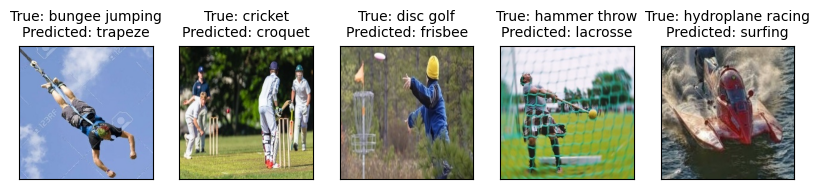

In [327]:
import matplotlib.pyplot as plt
import cv2

fig, axs = plt.subplots(1, 5, figsize=(10, 3))
axs[0].imshow(np.flip(cv2.imread(
    WRONG_DF.iloc[2,:][0]), axis=-1))

axs[1].imshow(np.flip(cv2.imread(
    WRONG_DF.iloc[3,:][0]), axis=-1))

axs[2].imshow(np.flip(cv2.imread(
    WRONG_DF.iloc[4,:][0]), axis=-1))

axs[3].imshow(np.flip(cv2.imread(
    WRONG_DF.iloc[5,:][0]), axis=-1))

axs[4].imshow(np.flip(cv2.imread(
    WRONG_DF.iloc[6,:][0]), axis=-1))

axs[0].set_title(f"True: {WRONG_DF.iloc[2,:][2]}\n"
                 f"Predicted: {WRONG_DF.iloc[2,:][3]}", size=10)

axs[1].set_title(f"True: {WRONG_DF.iloc[3,:][2]}\n"
                 f"Predicted: {WRONG_DF.iloc[3,:][3]}", size=10)

axs[2].set_title(f"True: {WRONG_DF.iloc[4,:][2]}\n"
                 f"Predicted: {WRONG_DF.iloc[4,:][3]}", size=10)

axs[3].set_title(f"True: {WRONG_DF.iloc[5,:][2]}\n"
                 f"Predicted: {WRONG_DF.iloc[5,:][3]}", size=10)

axs[4].set_title(f"True: {WRONG_DF.iloc[6,:][2]}\n"
                 f"Predicted: {WRONG_DF.iloc[6,:][3]}", size=10)



axs[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs[2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs[3].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs[4].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

fig.savefig('Wrong_images.png')